<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [3]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 86% 102M/119M [00:00<00:00, 198MB/s] 
100% 119M/119M [00:00<00:00, 196MB/s]


## Preprocesamiento de datos



In [4]:
#Homogenizar los nombres de carpetas

!mv Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/train/adenocarcinoma

!mv Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/train/large.cell.carcinoma

!mv Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/train/squamous.cell.carcinoma

!mv Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Data/valid/adenocarcinoma

!mv Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Data/valid/large.cell.carcinoma

!mv Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Data/valid/squamous.cell.carcinoma

In [5]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [51]:
input_size = (224, 224)

datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Construcción del modelo


In [52]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

for layer in base_model.layers :
  layer.trainable = False

In [54]:
from tensorflow.keras.regularizers import l2


model = Sequential()
num_classes = len(train_generator.class_indices)


# Add the VGG16 base model
model.add(base_model)
# model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))  # Aumentar unidades y agregar regularización
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Aumentar unidades y agregar regularización
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [55]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 100
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
    )



Epoch 1/100
20/20 [==============================] - 6s 226ms/step - loss: 21.0473 - accuracy: 0.3442 - val_loss: 12.9812 - val_accuracy: 0.5694
Epoch 2/100
20/20 [==============================] - 5s 239ms/step - loss: 11.5182 - accuracy: 0.4649 - val_loss: 9.1425 - val_accuracy: 0.5972
Epoch 3/100
20/20 [==============================] - 4s 215ms/step - loss: 8.3307 - accuracy: 0.5383 - val_loss: 7.3704 - val_accuracy: 0.4861
Epoch 4/100
20/20 [==============================] - 4s 207ms/step - loss: 6.7421 - accuracy: 0.6183 - val_loss: 6.4631 - val_accuracy: 0.5556
Epoch 5/100
20/20 [==============================] - 6s 284ms/step - loss: 5.8060 - accuracy: 0.6591 - val_loss: 5.5853 - val_accuracy: 0.5417
Epoch 6/100
20/20 [==============================] - 4s 209ms/step - loss: 5.0818 - accuracy: 0.7308 - val_loss: 4.8510 - val_accuracy: 0.7500
Epoch 7/100
20/20 [==============================] - 4s 210ms/step - loss: 4.5572 - accuracy: 0.7684 - val_loss: 4.3753 - val_accuracy: 0.7

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)              

In [58]:
model.evaluate(test_generator)

10/10 [==============================] - 3s 246ms/step - loss: 0.9923 - accuracy: 0.7619


[0.9923372864723206, 0.761904776096344]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

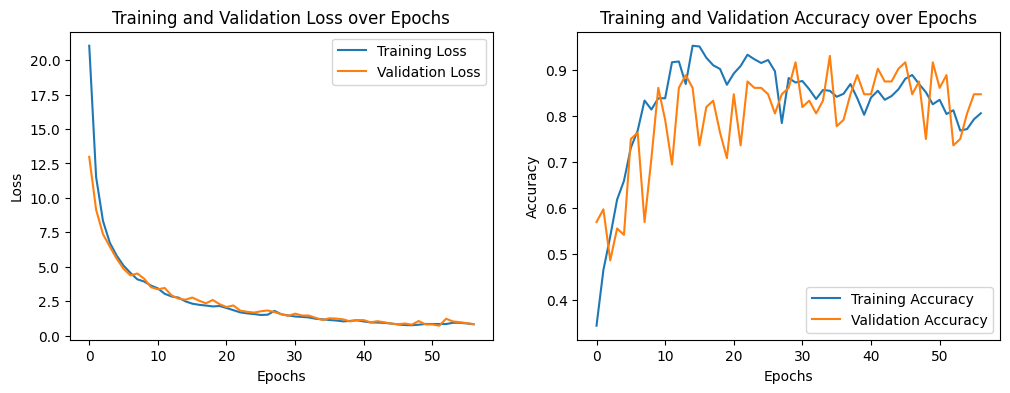

In [59]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

10/10 [==============================] - 82s 189ms/step


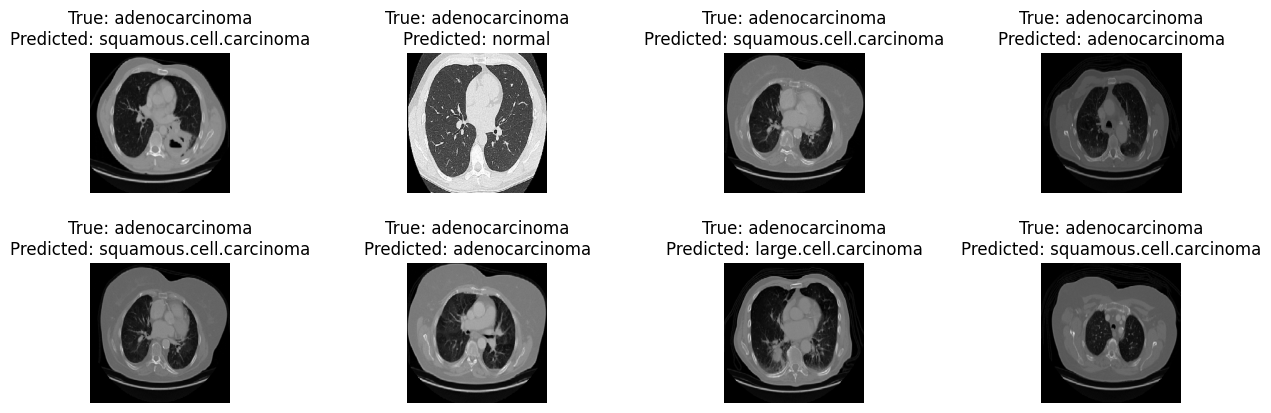

In [60]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


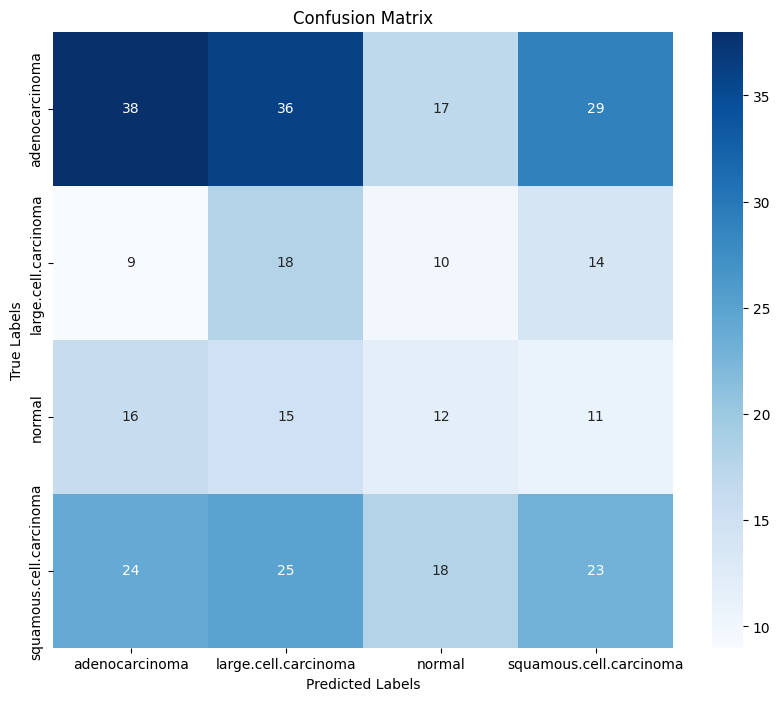

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()